In [1]:
%reset -fs
import pandas as pd
import  numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from dask import dataframe as dd
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.options.mode.use_inf_as_na = True

In [2]:
#Dask !!!
ddf = dd.read_csv(r"C:\Users\nated\Downloads\CSV-01-12\01-12\DrDoS_LDAP.csv", dtype={'SimillarHTTP': 'object'},blocksize='64MB')
df = ddf.compute()

In [3]:
df.columns = df.columns.str.replace(' ', '')
df.columns

Index(['Unnamed:0', 'FlowID', 'SourceIP', 'SourcePort', 'DestinationIP',
       'DestinationPort', 'Protocol', 'Timestamp', 'FlowDuration',
       'TotalFwdPackets', 'TotalBackwardPackets', 'TotalLengthofFwdPackets',
       'TotalLengthofBwdPackets', 'FwdPacketLengthMax', 'FwdPacketLengthMin',
       'FwdPacketLengthMean', 'FwdPacketLengthStd', 'BwdPacketLengthMax',
       'BwdPacketLengthMin', 'BwdPacketLengthMean', 'BwdPacketLengthStd',
       'FlowBytes/s', 'FlowPackets/s', 'FlowIATMean', 'FlowIATStd',
       'FlowIATMax', 'FlowIATMin', 'FwdIATTotal', 'FwdIATMean', 'FwdIATStd',
       'FwdIATMax', 'FwdIATMin', 'BwdIATTotal', 'BwdIATMean', 'BwdIATStd',
       'BwdIATMax', 'BwdIATMin', 'FwdPSHFlags', 'BwdPSHFlags', 'FwdURGFlags',
       'BwdURGFlags', 'FwdHeaderLength', 'BwdHeaderLength', 'FwdPackets/s',
       'BwdPackets/s', 'MinPacketLength', 'MaxPacketLength',
       'PacketLengthMean', 'PacketLengthStd', 'PacketLengthVariance',
       'FINFlagCount', 'SYNFlagCount', 'RSTFlagCount

In [4]:
(df['Label'].value_counts()) / len(df) * 100

DrDoS_LDAP    99.926107
BENIGN         0.073893
Name: Label, dtype: float64

In [5]:
df.drop(columns=['FlowID', 'SourceIP', 'DestinationIP', 'Timestamp', 'SimillarHTTP', 'SourcePort', 'DestinationPort'], inplace=True)
df

,Unnamed:0,Protocol,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,BwdPacketLengthMax,BwdPacketLengthMin,BwdPacketLengthMean,BwdPacketLengthStd,FlowBytes/s,FlowPackets/s,FlowIATMean,FlowIATStd,FlowIATMax,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATStd,FwdIATMax,FwdIATMin,BwdIATTotal,BwdIATMean,BwdIATStd,BwdIATMax,BwdIATMin,FwdPSHFlags,BwdPSHFlags,FwdURGFlags,BwdURGFlags,FwdHeaderLength,BwdHeaderLength,FwdPackets/s,BwdPackets/s,MinPacketLength,MaxPacketLength,PacketLengthMean,PacketLengthStd,PacketLengthVariance,FINFlagCount,SYNFlagCount,RSTFlagCount,PSHFlagCount,ACKFlagCount,URGFlagCount,CWEFlagCount,ECEFlagCount,Down/UpRatio,AveragePacketSize,AvgFwdSegmentSize,AvgBwdSegmentSize,FwdHeaderLength.1,FwdAvgBytes/Bulk,FwdAvgPackets/Bulk,FwdAvgBulkRate,BwdAvgBytes/Bulk,BwdAvgPackets/Bulk,BwdAvgBulkRate,SubflowFwdPackets,SubflowFwdBytes,SubflowBwdPackets,SubflowBwdBytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Inbound,Label
0,21010,0,9141643,85894,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,9.398967e+03,106.39591,209.905159,2968.0,0.0,9141643.0,106.430594,209.94653,2968.0,0.0,8487477.0,314351.0,1.147263e+06,5975703.0,0.0,0,0,0,0,0,0,9.395904e+03,3.062907,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,85894,0,28,0,-1,-1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,DrDoS_LDAP
1,20932,17,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,2.944000e+09,2.000000e+06,1.00000,0.000000,1.0,1.0,1.0,1.000000,0.00000,1.0,1.0,0.0,0.0,0.000000e+00,0.0,0.0,0,0,0,0,-2,0,2.000000e+06,0.000000,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,-2,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,DrDoS_LDAP
2,27876,17,2,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,1.472000e+09,1.000000e+06,2.00000,0.000000,2.0,2.0,2.0,2.000000,0.00000,2.0,2.0,0.0,0.0,0.000000e+00,0.0,0.0,0,0,0,0,-2,0,1.000000e+06,0.000000,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,-2,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,DrDoS_LDAP
3,24270,17,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,2.944000e+09,2.000000e+06,1.00000,0.000000,1.0,1.0,1.0,1.000000,0.00000,1.0,1.0,0.0,0.0,0.000000e+00,0.0,0.0,0,0,0,0,-2,0,2.000000e+06,0.000000,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,-2,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,DrDoS_LDAP
4,5109,17,2,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,1.472000e+09,1.000000e+06,2.00000,0.000000,2.0,2.0,2.0,2.000000,0.00000,2.0,2.0,0.0,0.0,0.000000e+00,0.0,0.0,0,0,0,0,-2,0,1.000000e+06,0.000000,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,-2,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,DrDoS_LDAP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50818,4277,17,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,2.944000e+09,2.000000e+06,1.00000,0.000000,1.0,1.0,1.0,1.000000,0.00000,1.0,1.0,0.0,0.0,0.000000e+00,0.0,0.0,0,0,0,0,0,0,2.000000e+06,0.000000,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,0,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,DrDoS_LDAP
50819,20369,17,1,2,0,2480.0,0.0,1240.0,1240.0,1240.0,0.0,0.0,0.0,0.0,0.0,2.480000e+09,2.000000e+06,1.00000,0.000000,1.0,1.0,1.0,1.000000,0.00000,1.0,1.0,0.0,0.0,0.000000e+00,0.0,0.0,0,0,0,0,0,0,2.000000e+06,0.000000,1240.0,1240.0,1240.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,1860.0,1240.0,0.0,0,0,0,0,0,0,0,2,2480,0,0,-

In [6]:
df.dropna(inplace=True)

In [7]:
cols = df.drop(columns=['Label']).columns.tolist()
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

In [8]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()

In [9]:
X = df.drop(columns=["Label"])
y = df.Label

In [10]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs', max_iter=1000000, n_jobs=-1)

In [11]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = .2, stratify=y)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25 stratify=y_train_val)

In [13]:
(y_train.value_counts()) / len(y_train) * 100

DrDoS_LDAP    99.925749
BENIGN         0.074251
Name: Label, dtype: float64

In [14]:
X_train_scaled = std.fit_transform(X_train)

In [15]:
import joblib
from dask.distributed import Client

client = Client(processes=False)

In [17]:
with joblib.parallel_backend("dask"):
    lr.fit(X_train_scaled, y_train)
    

In [18]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix

In [19]:
X_val_scaled = std.transform(X_val)

In [20]:
y_val_preds = lr.predict(X_val_scaled)
print("With default decision threshold:")
print("Precision: {}, Recall: {}".format(precision_score(y_val, y_val_preds, pos_label='BENIGN'), recall_score(y_val, y_val_preds, pos_label='BENIGN')))

With default decision threshold:
Precision: 0.9355932203389831, Recall: 0.9230769230769231


In [23]:
import seaborn as sns

Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

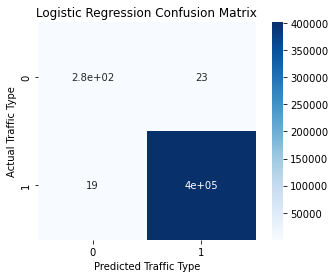

In [24]:
lr_confusion = confusion_matrix(y_val, y_val_preds)
sns.heatmap(lr_confusion, cmap=plt.cm.Blues, annot=True, square=True)
plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Logistic Regression Confusion Matrix')